In [3]:
import torch
import torch.nn as nn
from torch.autograd import grad

import pennylane as qml
from pennylane import numpy as pnp

import numpy as np  

import matplotlib.pyplot as plt  


In [4]:
m = 1.0
mu = 4.0
k = 400.0
lambda1 = 1e-1
lambda2 = 1e-4
lr = 0.002

In [5]:
n_qubits = 3
n_layers = 3


# Generate 200 evenly spaced time values between 0 and 1 using PennyLane NumPy.
# These values represent the training inputs for the PINN/QML model
t_train = pnp.linspace(0, 1, 200)


# Convert the NumPy array to a PyTorch tensor so it can be used as input
# to a PyTorch-based model and participate in the autograd computation graph.
# t_train_torch = torch.tensor(t_train, dtype=torch.float32)
t_train_torch = torch.tensor(t_train, dtype=torch.float32).reshape(-1, 1)

dev = qml.device("default.qubit", wires=n_qubits)

torch.manual_seed(0)
np.random.seed(0)

In [6]:
def ansatz_layer(theta):
    for i in range(n_qubits):
        qml.RZ(theta[i,0], wires=i)
        qml.RX(theta[i,1], wires=i)
        qml.RZ(theta[i,2], wires=i)

    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1) % n_qubits])

def feature_layer(phi):
    for i in range(n_qubits):
        qml.RY(phi[i], wires=i)

@qml.qnode(dev, interface="torch")
def quantum_block(phi, thetas):
    ansatz_layer(thetas[0])
    feature_layer(phi)
    ansatz_layer(thetas[1])
    feature_layer(phi)
    ansatz_layer(thetas[2])

    return qml.expval(qml.PauliZ(0))

In [7]:
class QuantumBranch(nn.Module):

    def __init__(self):
        super().__init__()

        # Ansatz parameter A(theta)
        self.theta = nn.Parameter(
            torch.randn(n_layers, n_qubits, 3) * 0.01
        )

    def forward(self, t):
        if t.dim() == 2:
            t = t.squeeze(-1)

        scale = np.pi

        # Feature map parameter
        phi = torch.stack([scale * t, 2.0 * scale * t, 3.0 * scale * t], dim=1)

        outputs = []
        for i in range(phi.size(0)):
            out = quantum_block(phi[i], self.theta)
            outputs.append(out)

        return torch.stack(outputs).unsqueeze(-1)

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.net(x)

In [9]:
class CQ_PINN(nn.Module):

    def __init__(self):
        super().__init__()
        self.branch1 = QuantumBranch()
        self.branch2 = MLP()

    def forward(self, t):
        return self.branch1(t) + self.branch2(t)

In [10]:
def derivative(u, t):
    return grad(
        outputs=u,
        inputs=t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

def second_derivative(u, t):
    du_dt = derivative(u, t)
    return derivative(du_dt, t)

In [11]:
def loss_fn(model, t):
    # Create a clean differentiable copy of t.
    # - detach(): remove previous graph history
    # - clone(): avoid in-place side effects
    # - requires_grad_(True): allow autograd to compute du/dt and d2u/dt2
    t = t.clone().detach().requires_grad_(True)

    u = model(t)
    du = derivative(u, t)
    d2u = second_derivative(u, t)

    f = m * d2u + mu * du + k * u

    t0 = torch.zeros((1, 1), dtype=t.dtype, device=t.device)
    t0.requires_grad_(True)
    u0 = model(t0)
    du0 = derivative(u0, t0)

    loss_ic_u  = (u0 - 1.0)**2
    loss_ic_du = du0**2
    loss_f = torch.mean(f**2)

    return loss_ic_u.squeeze(), loss_ic_du.squeeze(), loss_f.squeeze()

Epoch    0 | Loss = 2.6974e+00 | IC_u = 2.5149e-03 | IC_du = 1.2427e-02 | PDE = 2.6936e+04
||u||: 0.45539268967324065 ||u'||: 5.453683853149414 ||u''||: 114.39775085449219


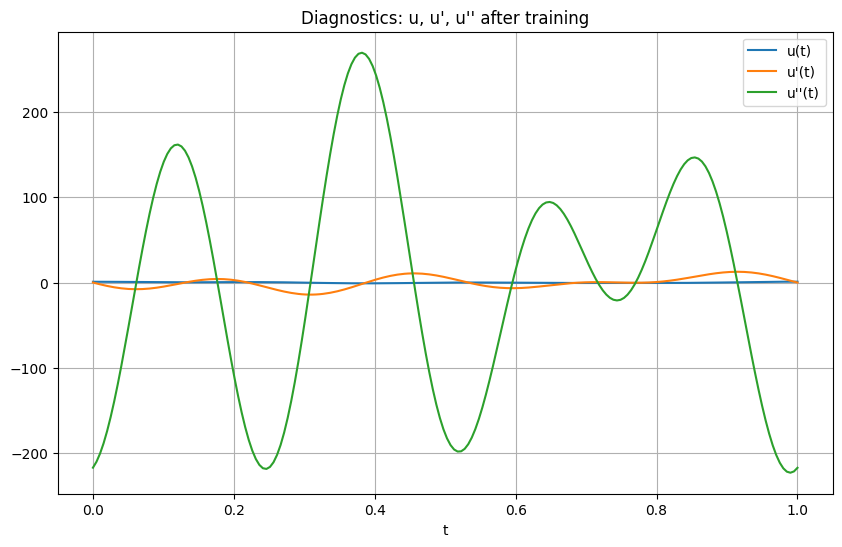

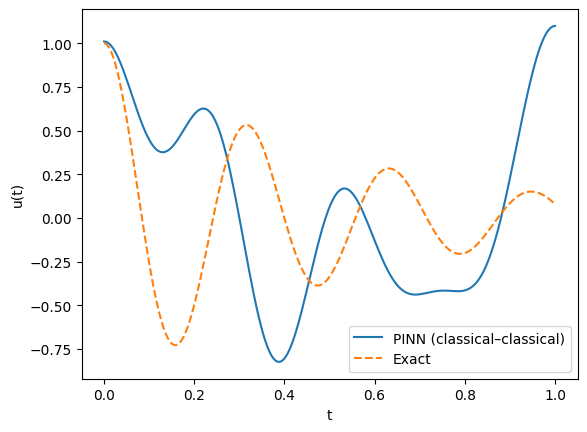

Epoch  100 | Loss = 1.2387e+00 | IC_u = 1.4533e-01 | IC_du = 1.4970e-02 | PDE = 1.0919e+04
||u||: 0.31135087533442446 ||u'||: 5.178586006164551 ||u''||: 114.41809844970703


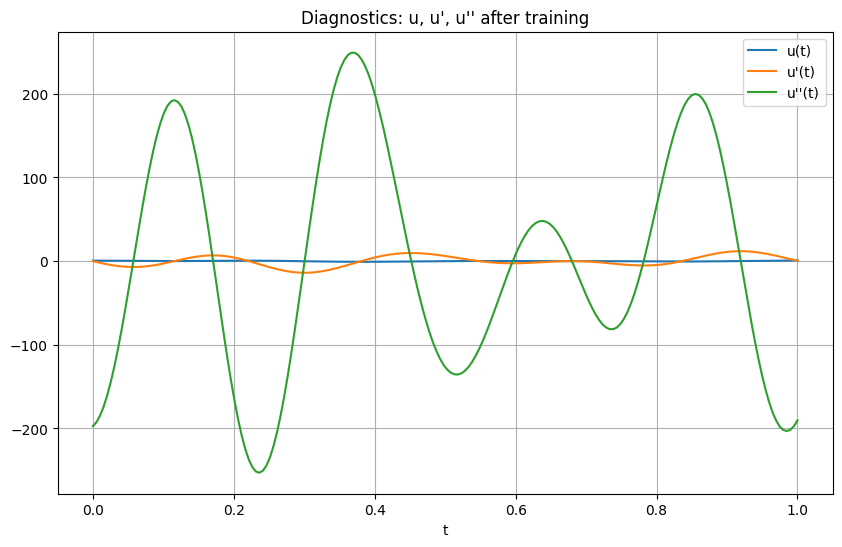

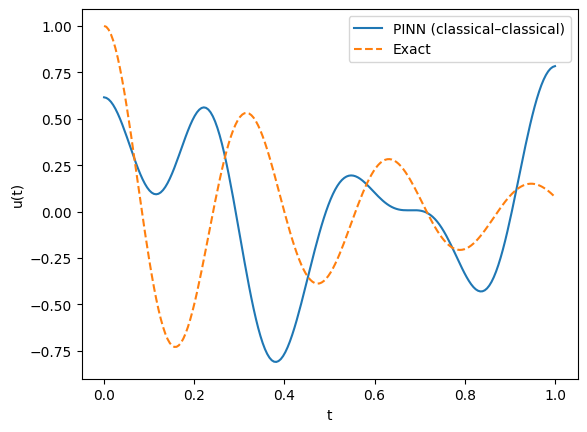

Epoch  200 | Loss = 6.7682e-01 | IC_u = 1.7010e-01 | IC_du = 4.6655e-02 | PDE = 5.0206e+03
||u||: 0.2477351649073547 ||u'||: 4.660673141479492 ||u''||: 107.32434844970703


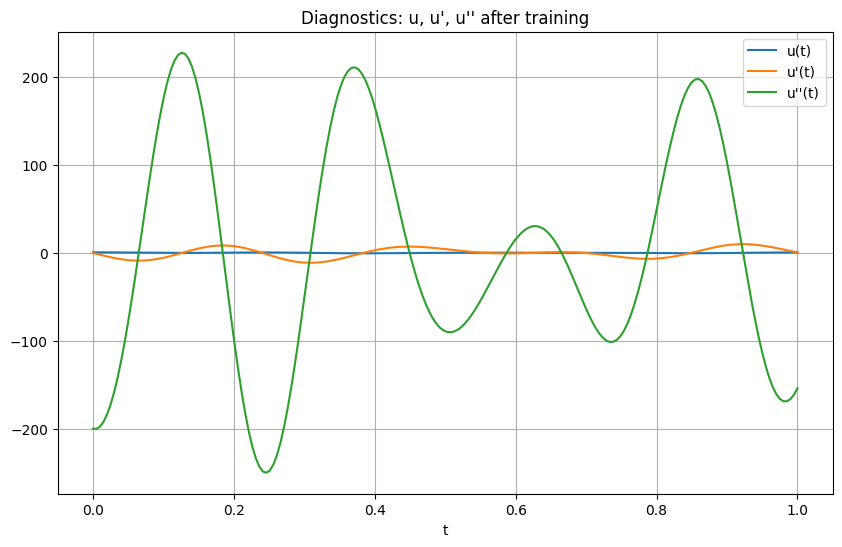

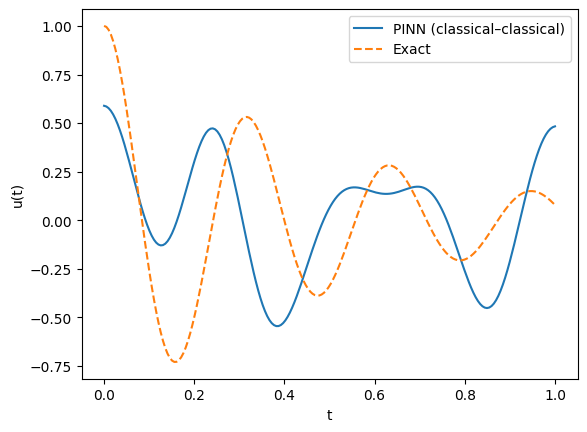

Epoch  300 | Loss = 3.8690e-01 | IC_u = 9.0121e-02 | IC_du = 2.6431e-02 | PDE = 2.9414e+03
||u||: 0.20819387730363778 ||u'||: 4.210694789886475 ||u''||: 101.5417251586914


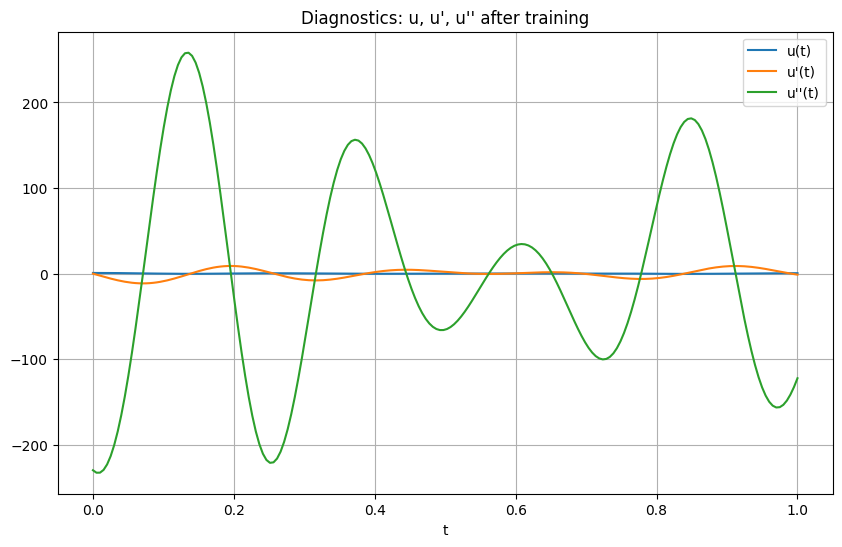

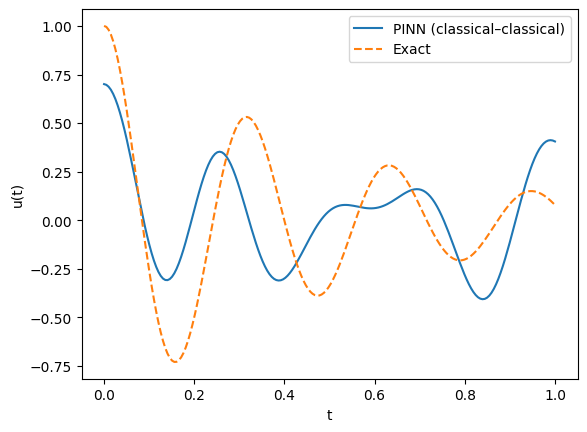

Epoch  400 | Loss = 2.5259e-01 | IC_u = 5.7703e-02 | IC_du = 1.2384e-02 | PDE = 1.9365e+03
||u||: 0.1876623962680182 ||u'||: 3.8760290145874023 ||u''||: 90.999267578125


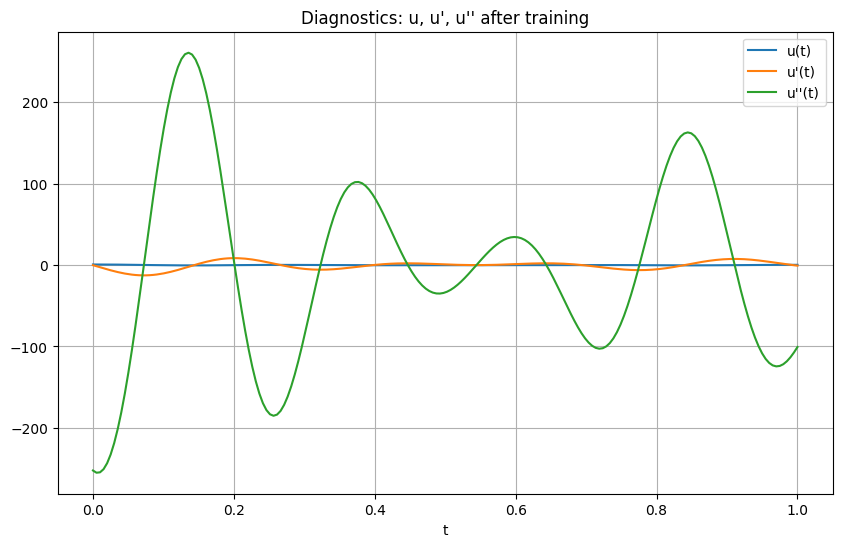

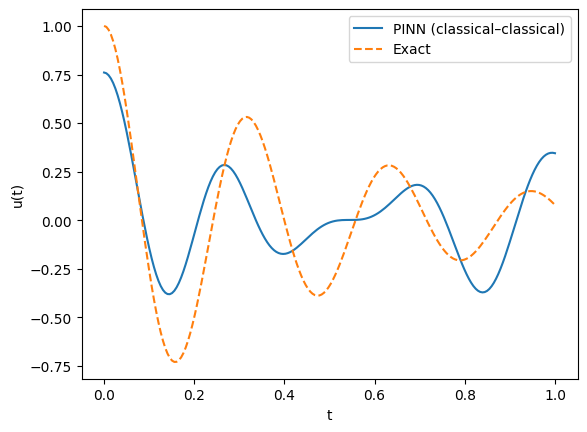

Epoch  500 | Loss = 1.7423e-01 | IC_u = 4.2453e-02 | IC_du = 4.4699e-03 | PDE = 1.3133e+03
||u||: 0.17703212357197398 ||u'||: 3.5450546741485596 ||u''||: 79.28133392333984


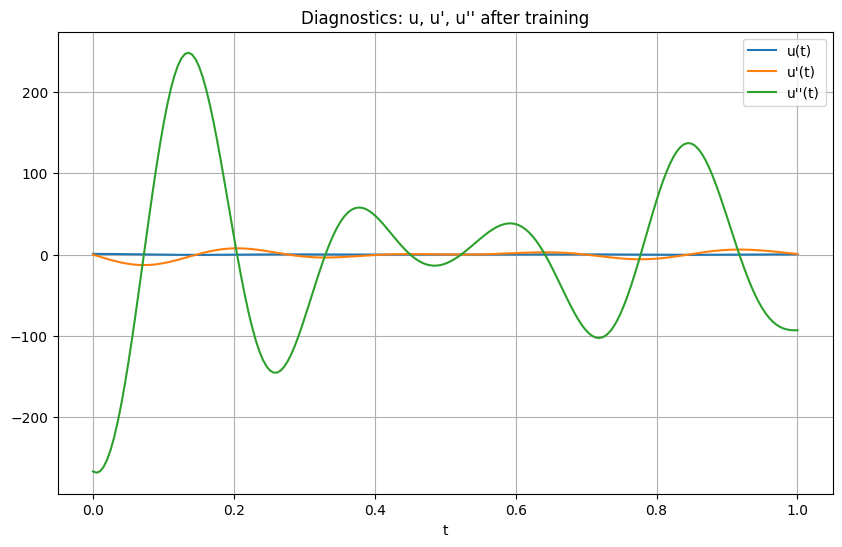

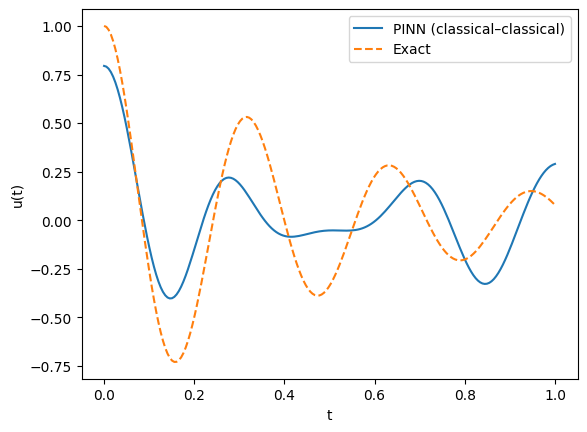

Epoch  600 | Loss = 1.3124e-01 | IC_u = 3.4119e-02 | IC_du = 2.0870e-03 | PDE = 9.6915e+02
||u||: 0.17239932391932944 ||u'||: 3.4001331329345703 ||u''||: 71.50993347167969


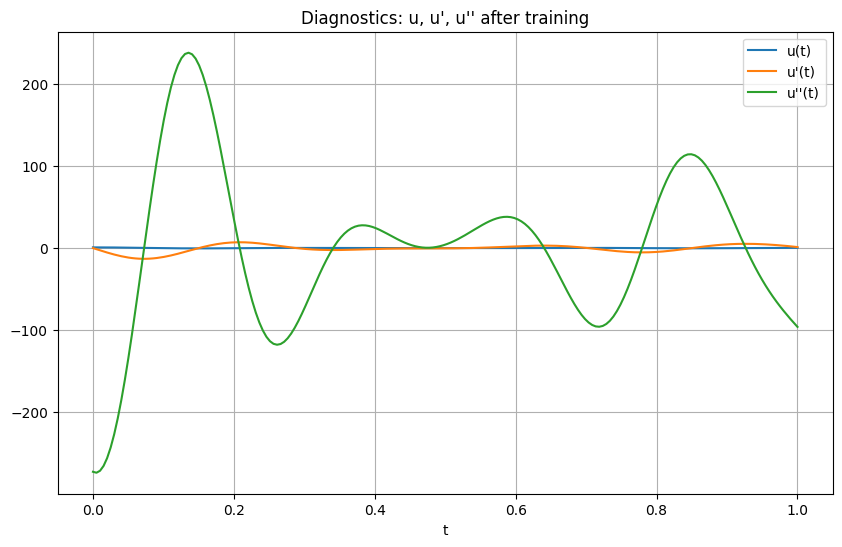

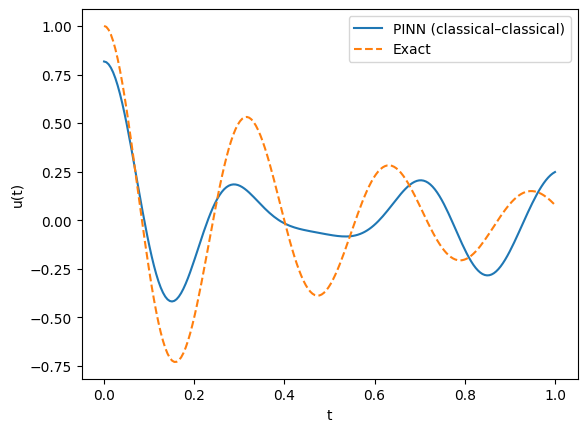

Epoch  700 | Loss = 1.0137e-01 | IC_u = 2.8350e-02 | IC_du = 1.0540e-03 | PDE = 7.2913e+02
||u||: 0.17346713975059921 ||u'||: 3.352844476699829 ||u''||: 68.53272247314453


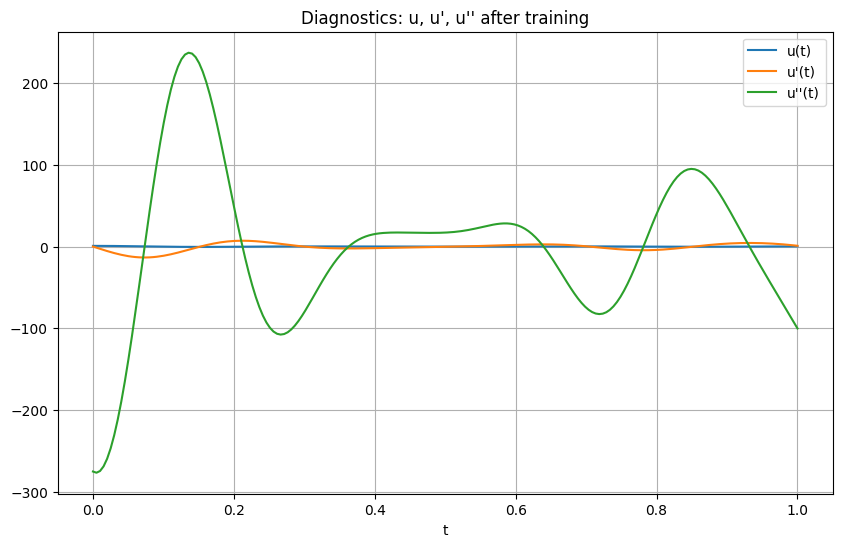

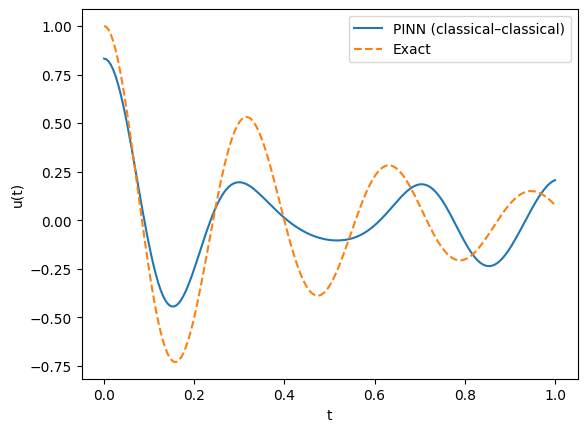

Epoch  800 | Loss = 7.7761e-02 | IC_u = 2.2858e-02 | IC_du = 4.8862e-04 | PDE = 5.4855e+02
||u||: 0.17533432830519813 ||u'||: 3.3494274616241455 ||u''||: 67.50548553466797


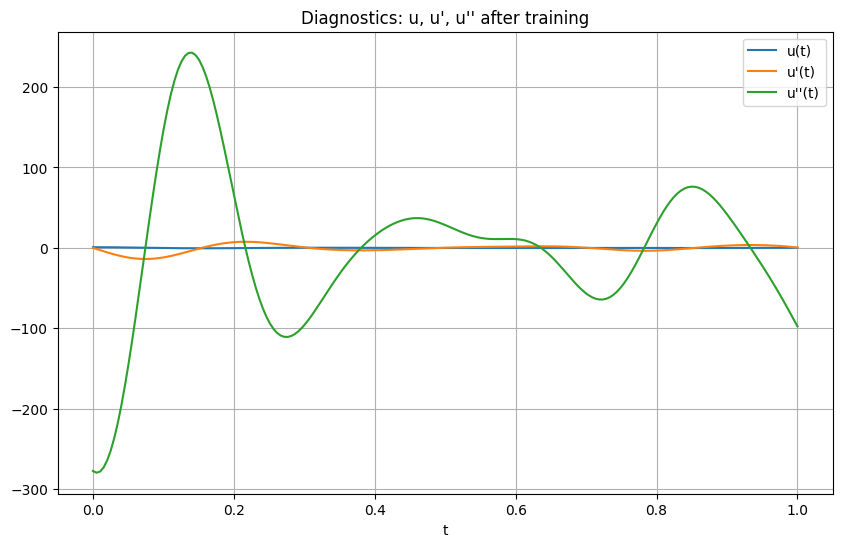

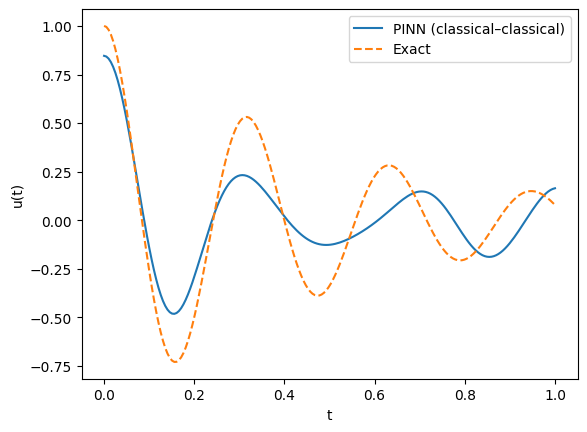

Epoch  900 | Loss = 5.9000e-02 | IC_u = 1.7897e-02 | IC_du = 3.6276e-04 | PDE = 4.1067e+02
||u||: 0.18067224234029364 ||u'||: 3.4333696365356445 ||u''||: 68.76609802246094


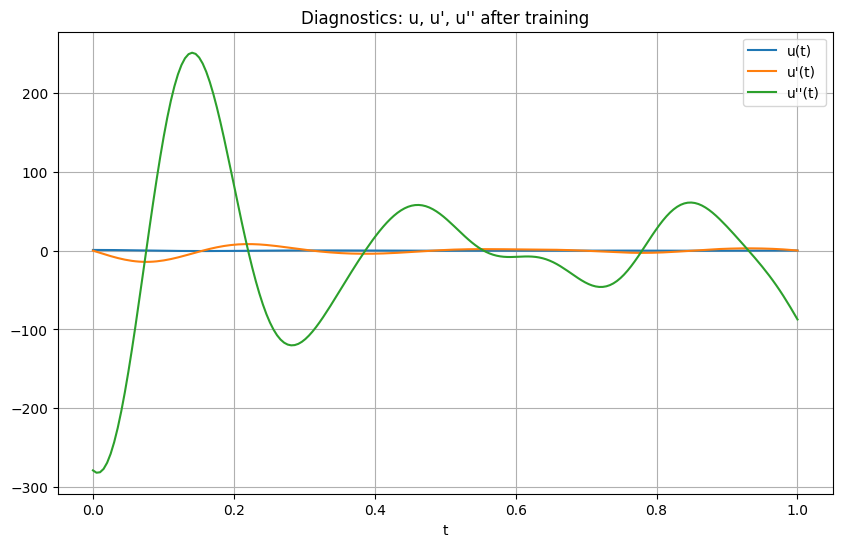

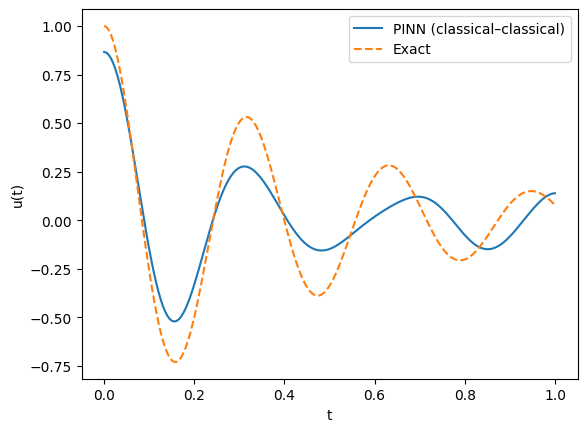

Epoch 1000 | Loss = 4.4931e-02 | IC_u = 1.3400e-02 | IC_du = 2.6667e-04 | PDE = 3.1504e+02
||u||: 0.18999351469699582 ||u'||: 3.591581106185913 ||u''||: 72.45333862304688


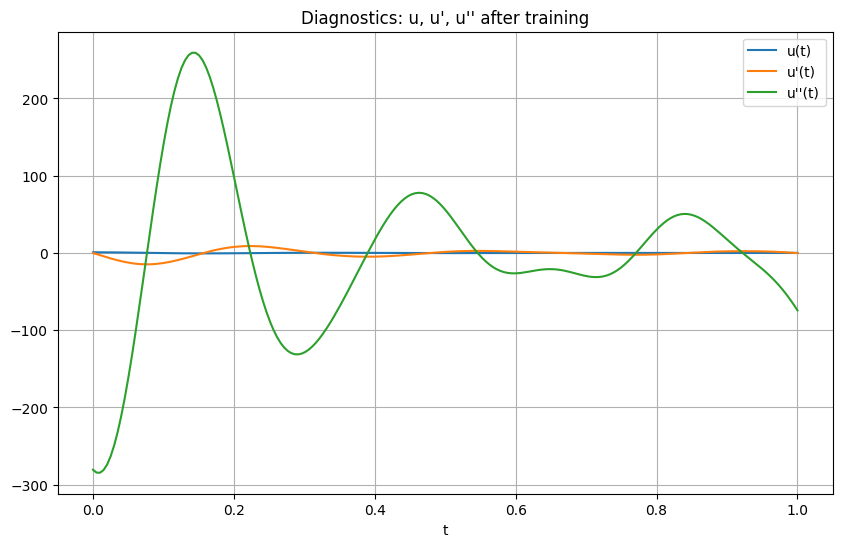

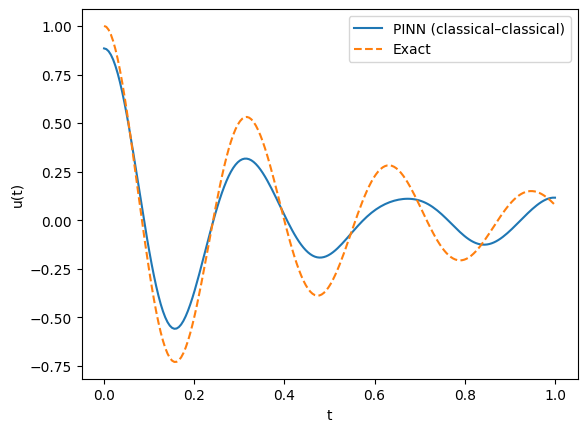

Epoch 1100 | Loss = 3.5639e-02 | IC_u = 1.0316e-02 | IC_du = 2.0370e-04 | PDE = 2.5302e+02
||u||: 0.19998610022307647 ||u'||: 3.7831456661224365 ||u''||: 76.21672821044922


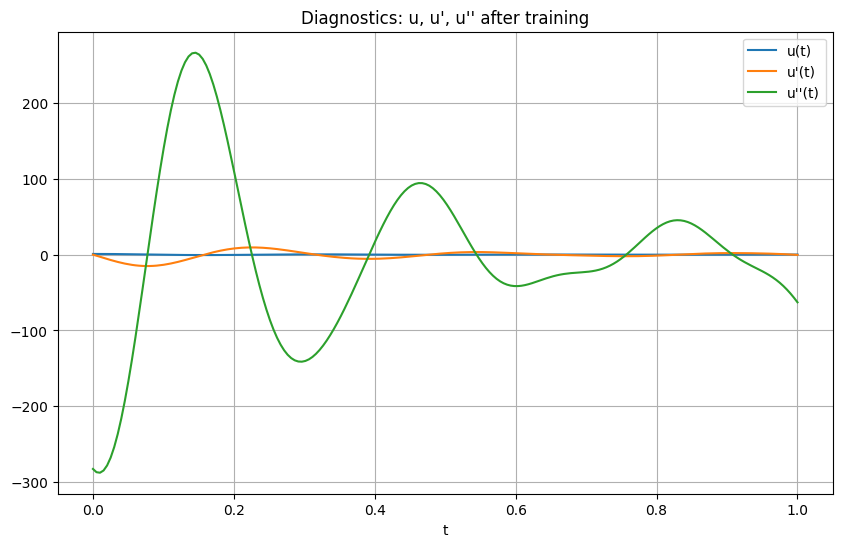

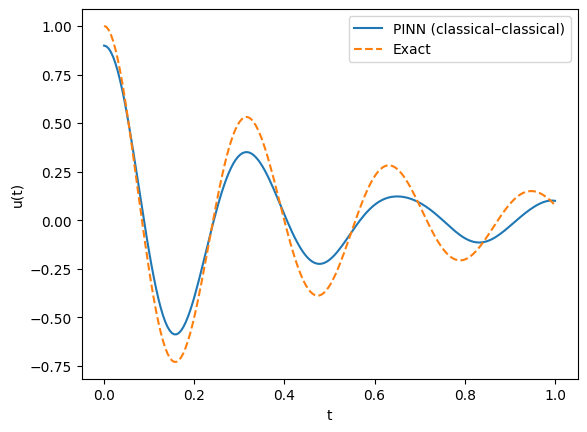

Epoch 1200 | Loss = 2.9923e-02 | IC_u = 8.2602e-03 | IC_du = 1.6011e-04 | PDE = 2.1647e+02
||u||: 0.20843532422428368 ||u'||: 3.9539194107055664 ||u''||: 79.6851577758789


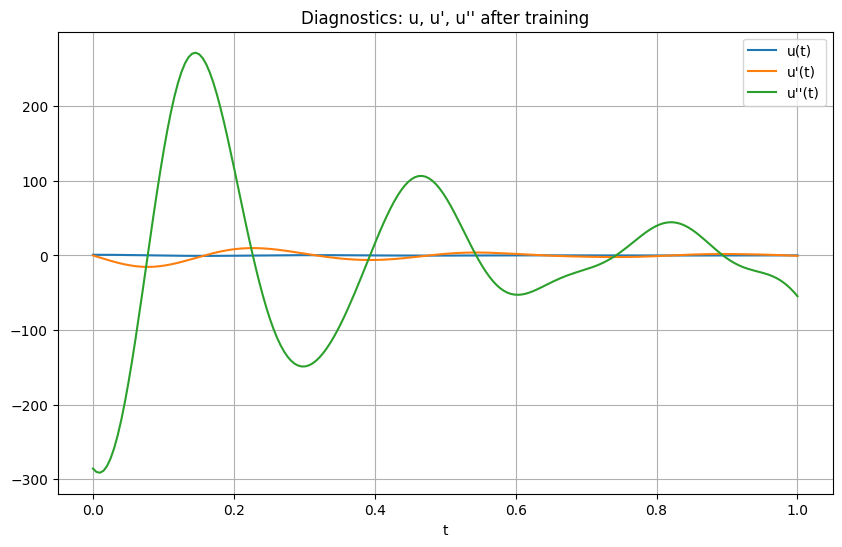

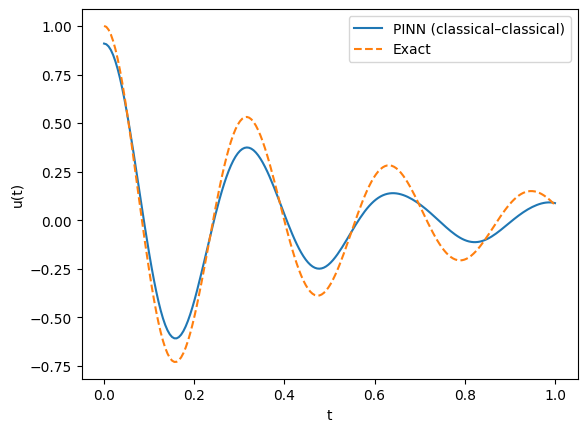

Epoch 1300 | Loss = 2.6371e-02 | IC_u = 6.9568e-03 | IC_du = 1.3283e-04 | PDE = 1.9400e+02
||u||: 0.21476228111723303 ||u'||: 4.084908962249756 ||u''||: 82.5344009399414


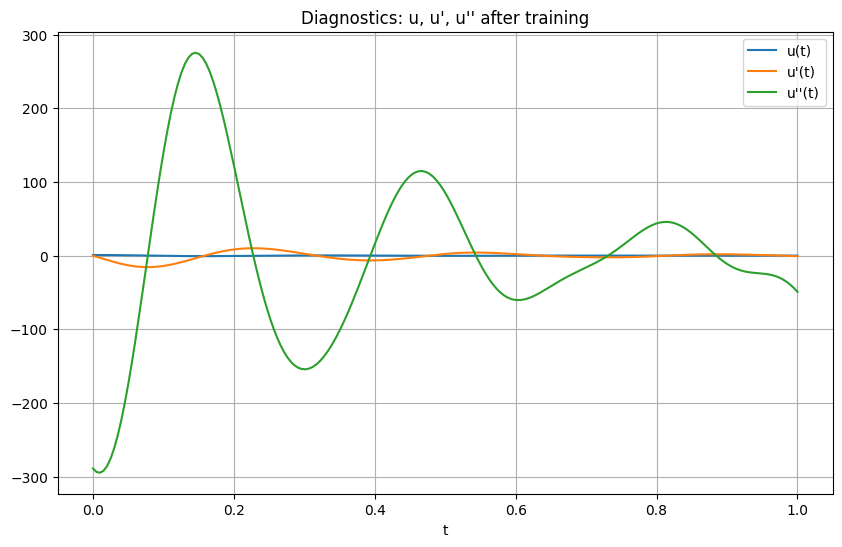

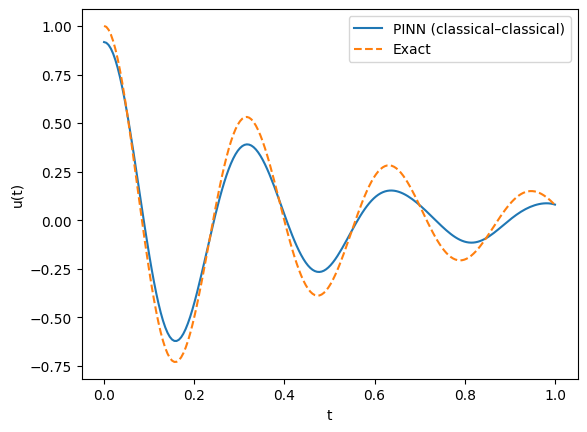

Epoch 1400 | Loss = 2.4008e-02 | IC_u = 6.0109e-03 | IC_du = 1.1253e-04 | PDE = 1.7986e+02
||u||: 0.21938410012142037 ||u'||: 4.181597709655762 ||u''||: 84.70698547363281


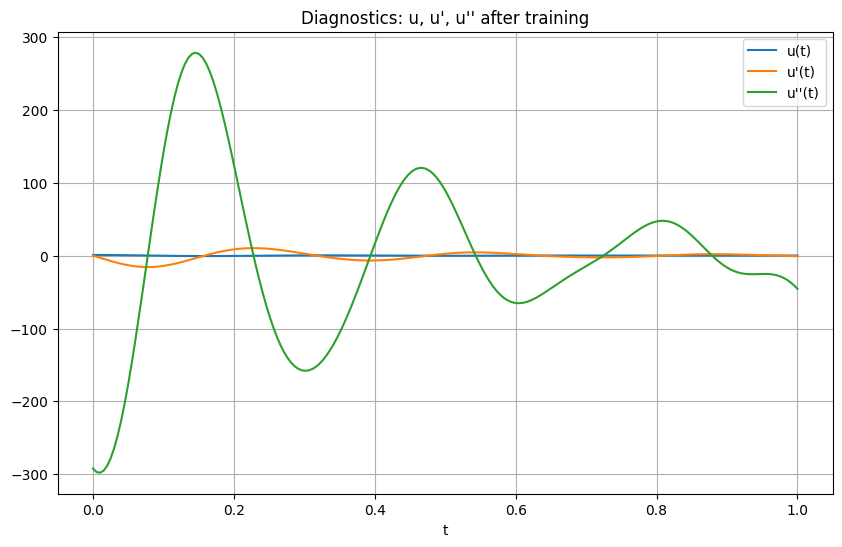

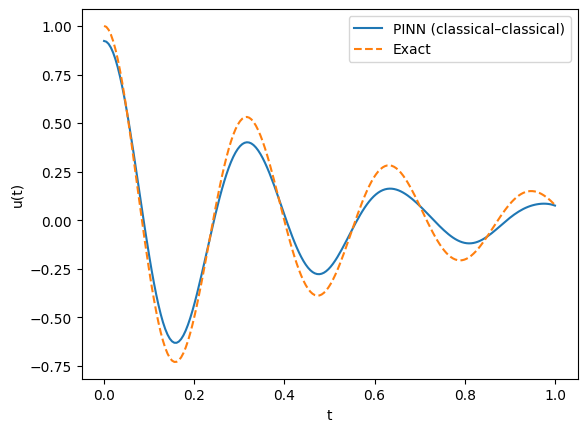

Epoch 1500 | Loss = 2.2345e-02 | IC_u = 5.4862e-03 | IC_du = 1.0635e-04 | PDE = 1.6848e+02
||u||: 0.22300975607085138 ||u'||: 4.256022930145264 ||u''||: 86.38337707519531


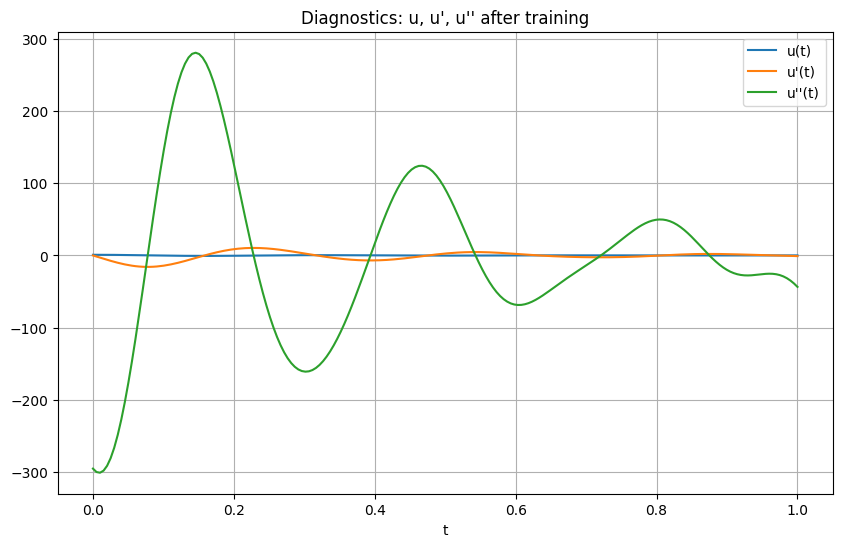

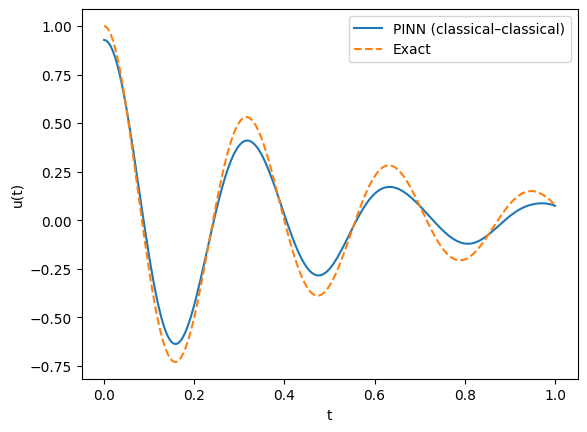

Epoch 1600 | Loss = 2.1013e-02 | IC_u = 4.8228e-03 | IC_du = 8.7852e-05 | PDE = 1.6181e+02
||u||: 0.22561778772811372 ||u'||: 4.3133769035339355 ||u''||: 87.65242004394531


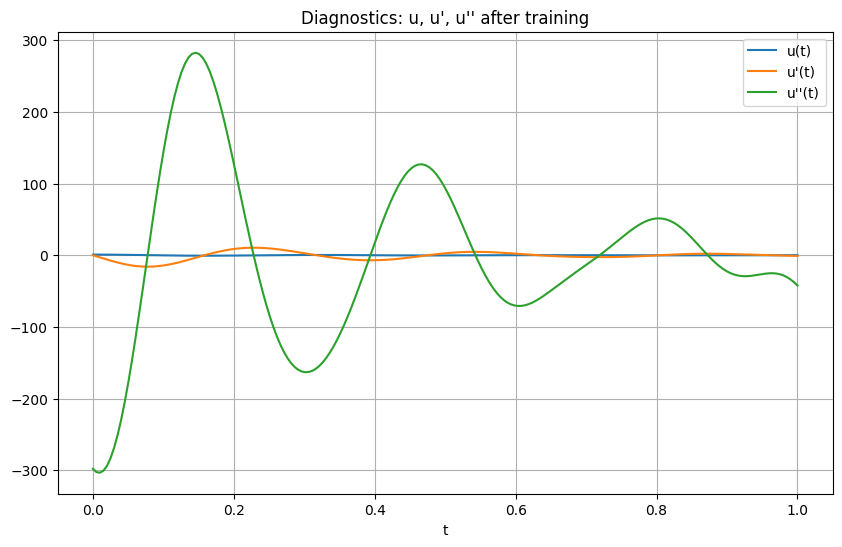

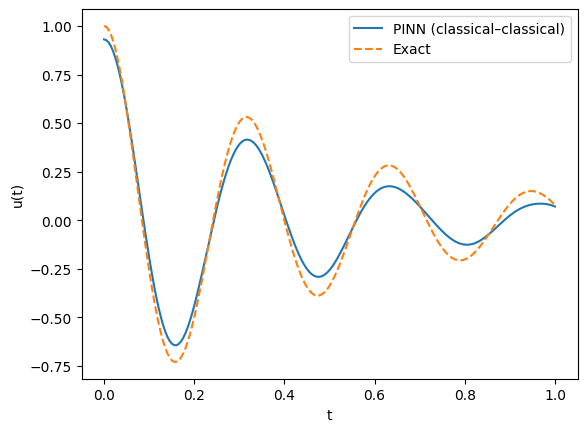

Epoch 1700 | Loss = 1.9953e-02 | IC_u = 4.4254e-03 | IC_du = 8.0635e-05 | PDE = 1.5520e+02
||u||: 0.22788706505650227 ||u'||: 4.360549449920654 ||u''||: 88.68498992919922


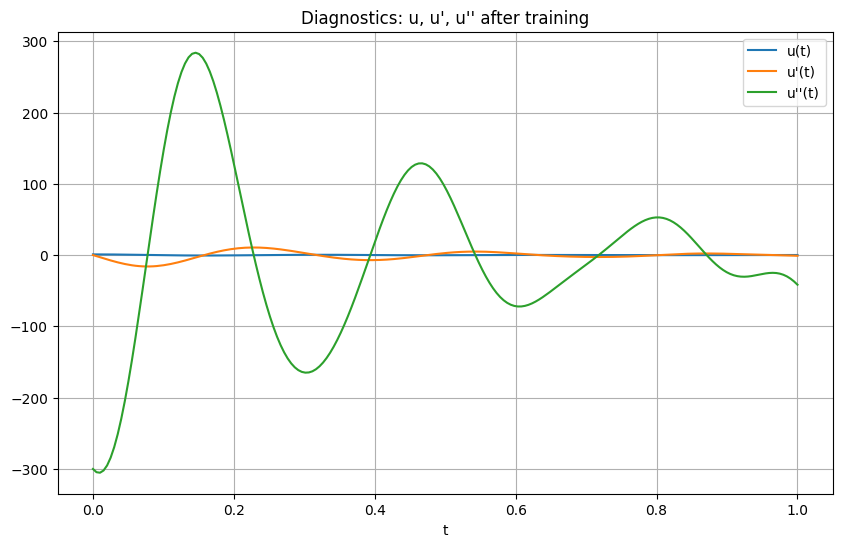

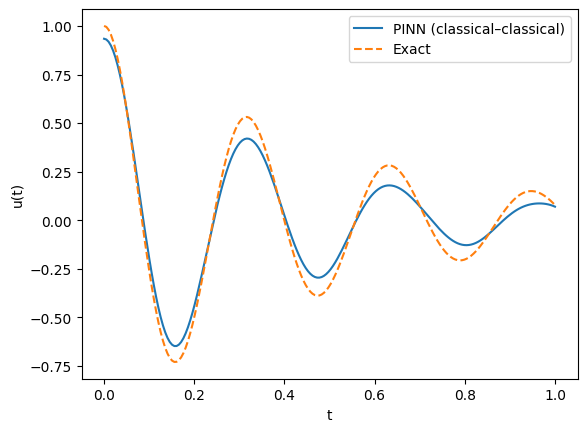

Epoch 1800 | Loss = 1.9060e-02 | IC_u = 4.0601e-03 | IC_du = 7.2079e-05 | PDE = 1.4993e+02
||u||: 0.22976576731894555 ||u'||: 4.4005866050720215 ||u''||: 89.53997802734375


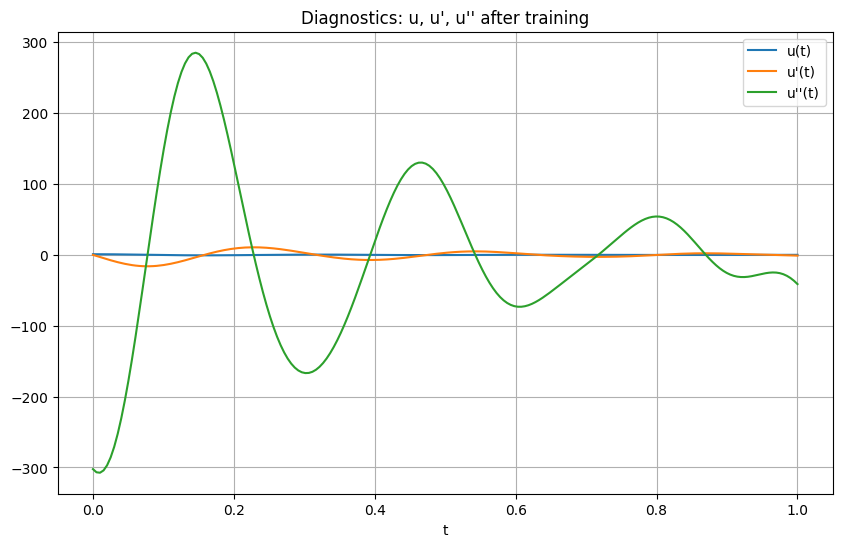

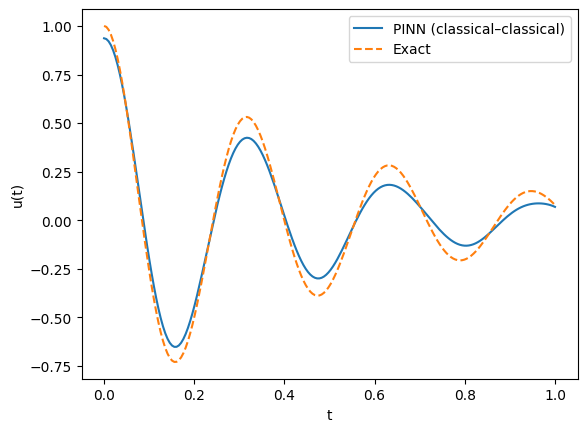

Epoch 1900 | Loss = 1.8280e-02 | IC_u = 3.7592e-03 | IC_du = 6.6143e-05 | PDE = 1.4515e+02
||u||: 0.2313728354470218 ||u'||: 4.4342122077941895 ||u''||: 90.25769805908203


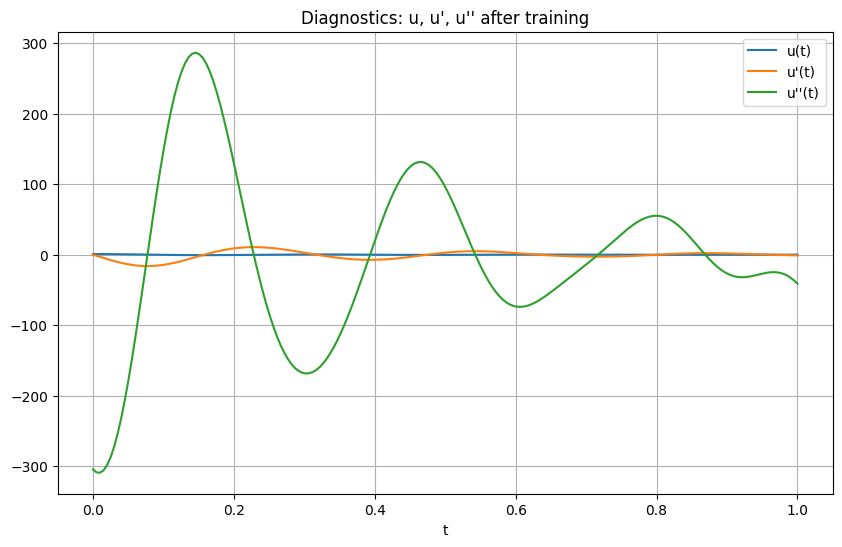

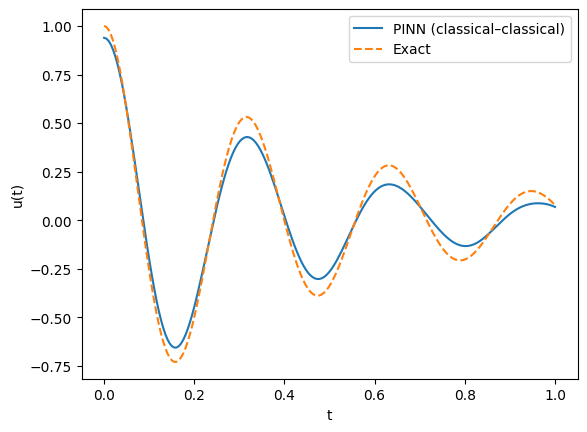

Epoch 2000 | Loss = 1.7590e-02 | IC_u = 3.5500e-03 | IC_du = 6.3765e-05 | PDE = 1.4033e+02
||u||: 0.2329692093142787 ||u'||: 4.464492321014404 ||u''||: 90.90727233886719


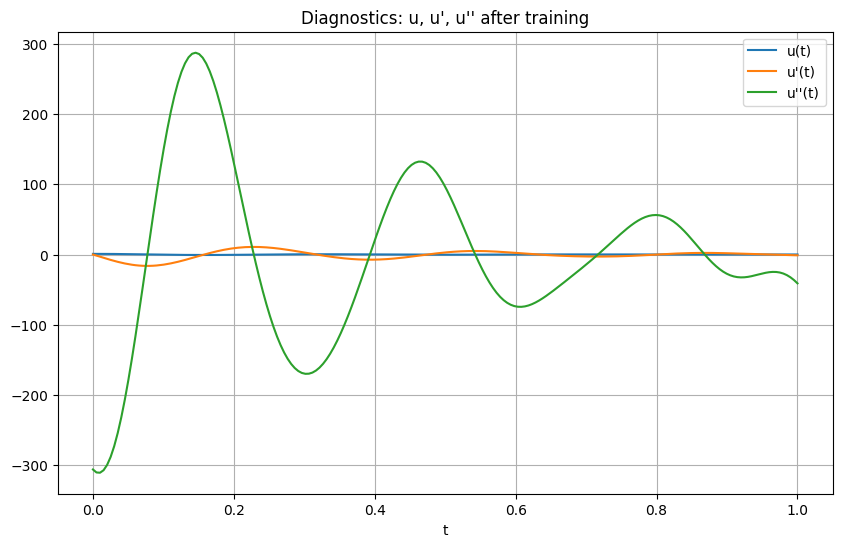

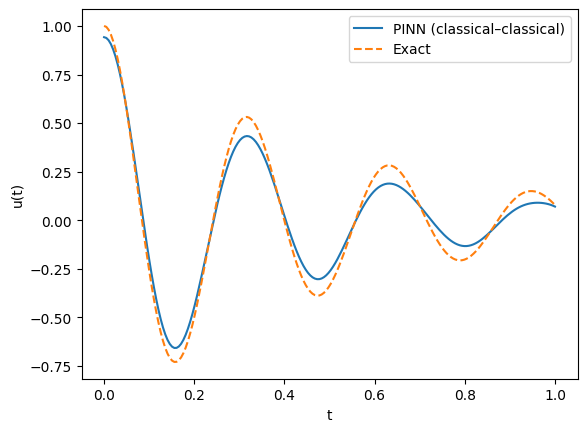

Epoch 2100 | Loss = 1.6961e-02 | IC_u = 3.2789e-03 | IC_du = 5.6721e-05 | PDE = 1.3677e+02
||u||: 0.23406160500572196 ||u'||: 4.4898576736450195 ||u''||: 91.4502944946289


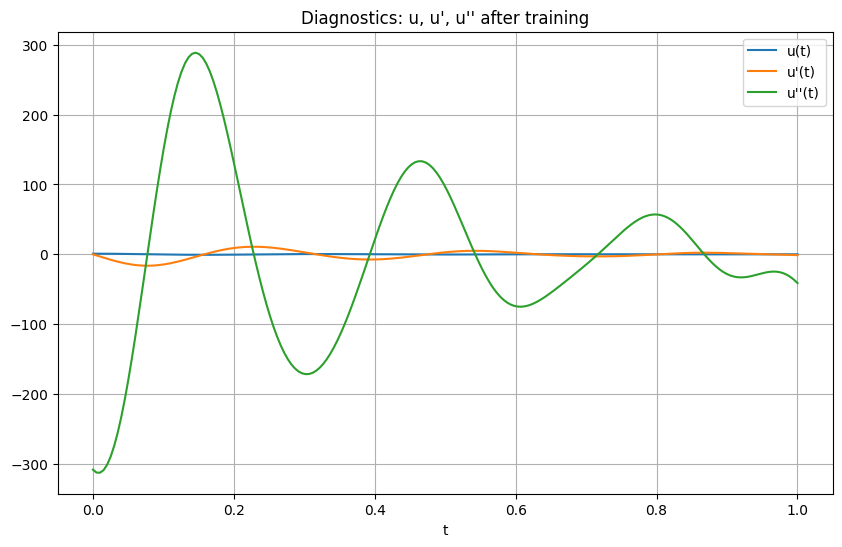

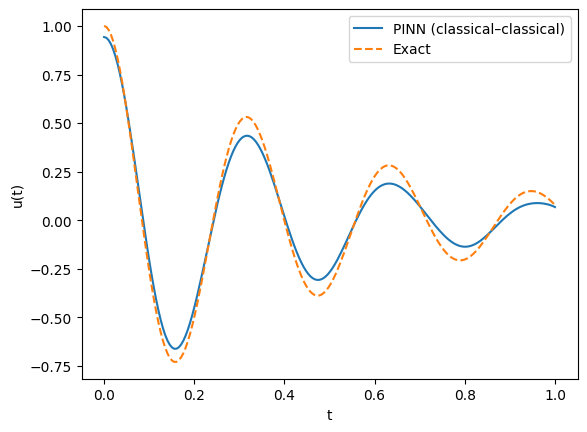

Epoch 2200 | Loss = 1.6386e-02 | IC_u = 3.0732e-03 | IC_du = 5.2964e-05 | PDE = 1.3308e+02
||u||: 0.2351870464633841 ||u'||: 4.513205051422119 ||u''||: 91.9505844116211


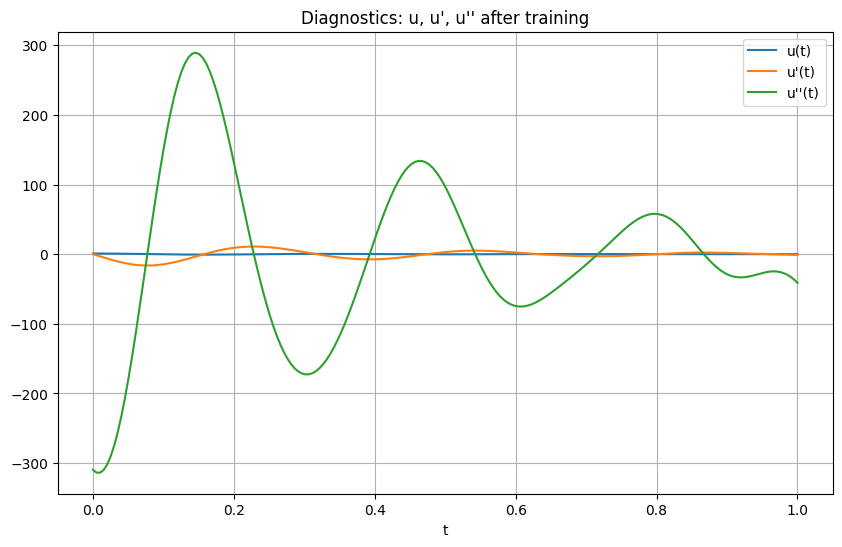

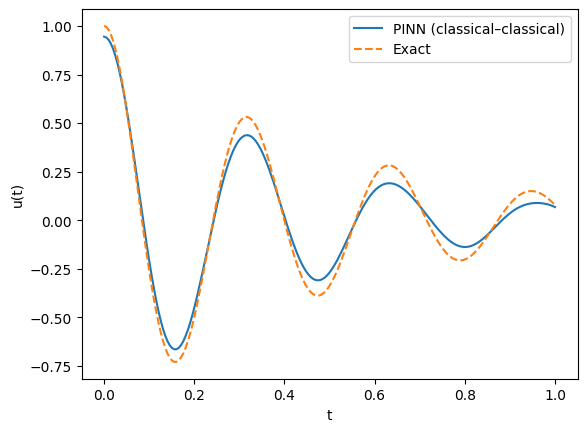

Epoch 2300 | Loss = 1.5858e-02 | IC_u = 2.9268e-03 | IC_du = 5.0948e-05 | PDE = 1.2927e+02
||u||: 0.23627417042028034 ||u'||: 4.535188674926758 ||u''||: 92.4189453125


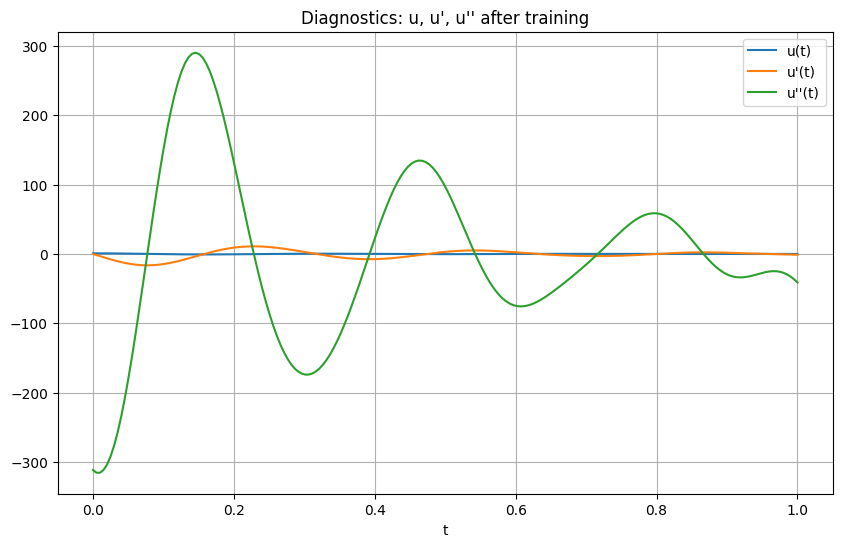

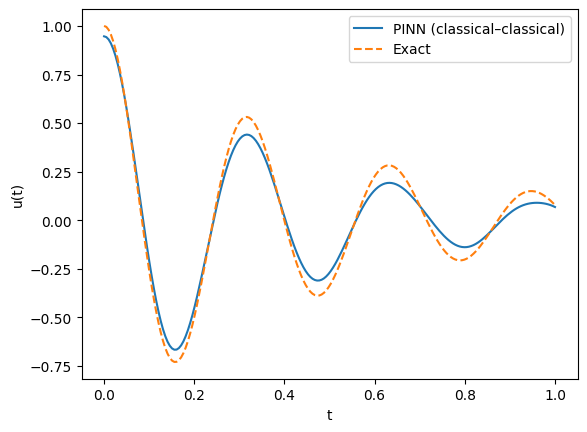

Epoch 2400 | Loss = 1.5361e-02 | IC_u = 2.7371e-03 | IC_du = 4.6816e-05 | PDE = 1.2620e+02
||u||: 0.23719653941236893 ||u'||: 4.554992198944092 ||u''||: 92.83872985839844


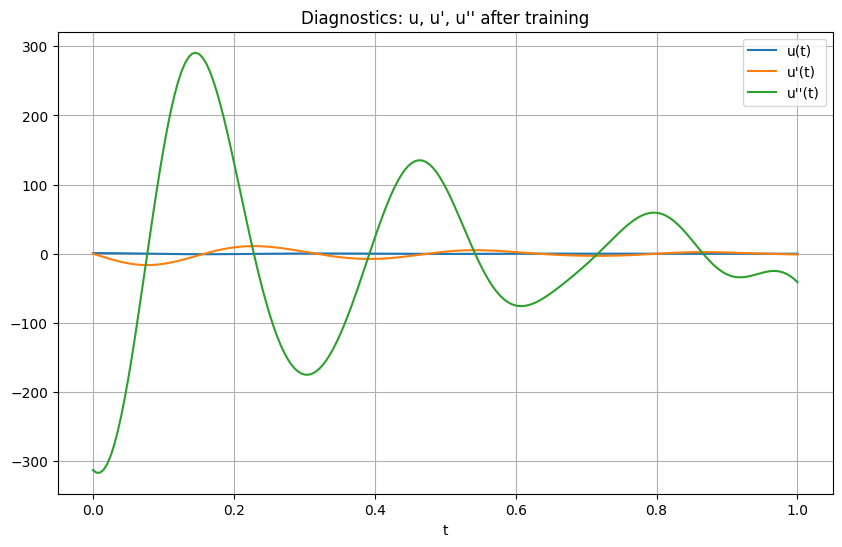

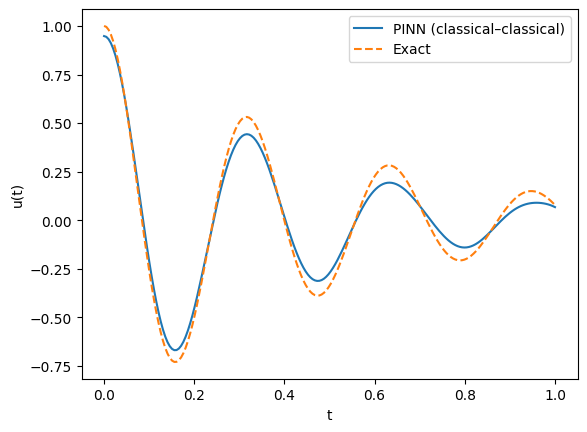

Epoch 2500 | Loss = 1.4900e-02 | IC_u = 2.6554e-03 | IC_du = 4.7566e-05 | PDE = 1.2240e+02
||u||: 0.23819554804299703 ||u'||: 4.574053764343262 ||u''||: 93.24107360839844


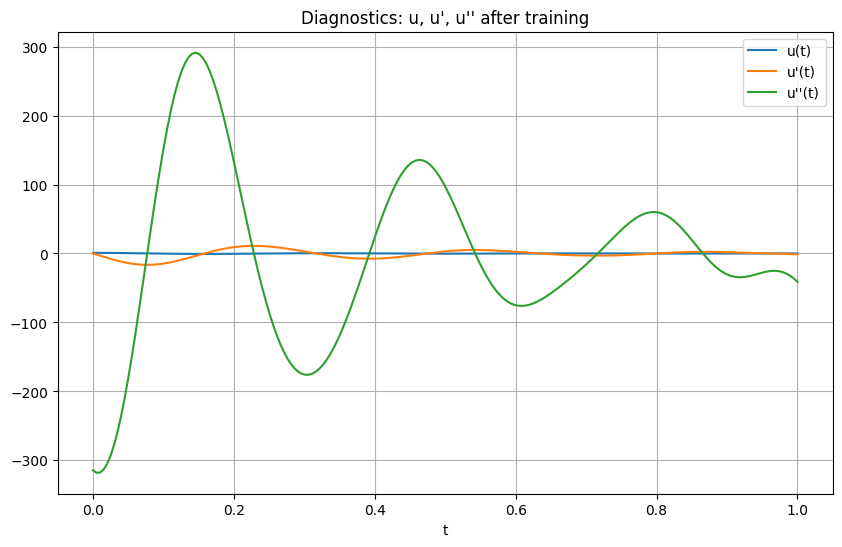

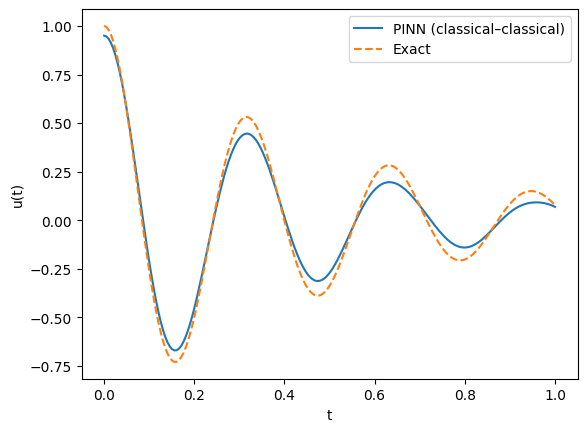

Epoch 2600 | Loss = 1.4436e-02 | IC_u = 2.4703e-03 | IC_du = 4.2428e-05 | PDE = 1.1962e+02
||u||: 0.23898204651008462 ||u'||: 4.592180252075195 ||u''||: 93.61909484863281


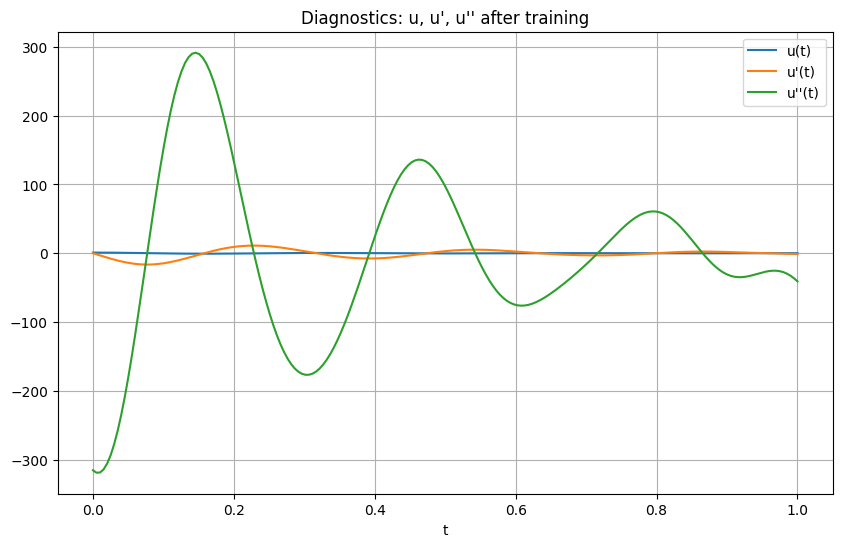

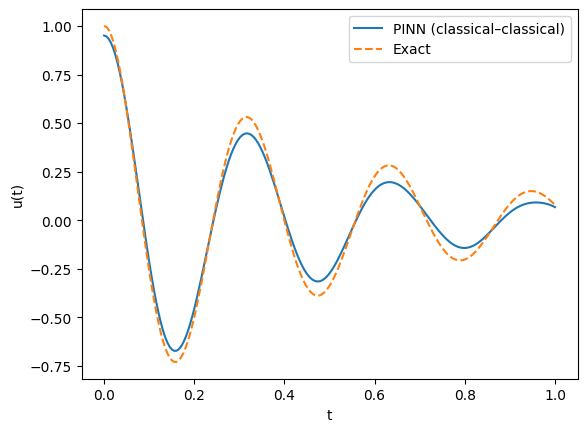

Epoch 2700 | Loss = 1.3992e-02 | IC_u = 2.3448e-03 | IC_du = 4.0227e-05 | PDE = 1.1643e+02
||u||: 0.23979547972202167 ||u'||: 4.6095476150512695 ||u''||: 93.97694396972656


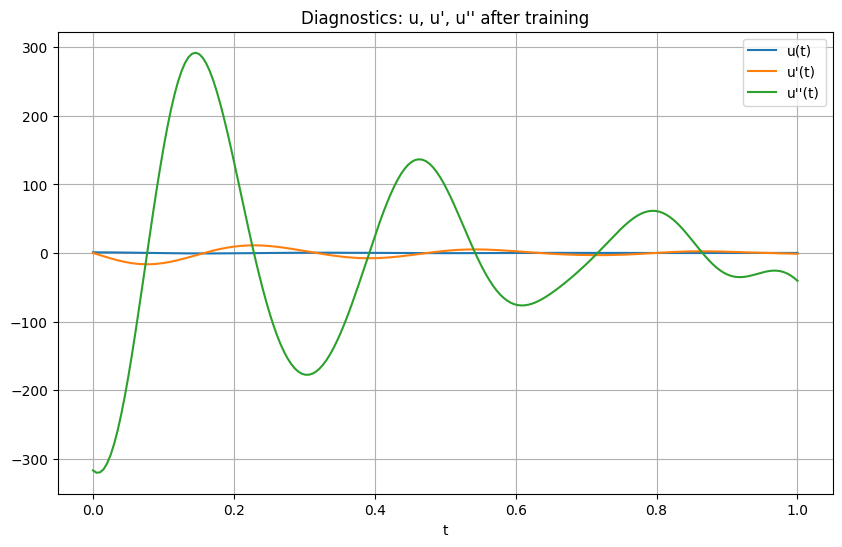

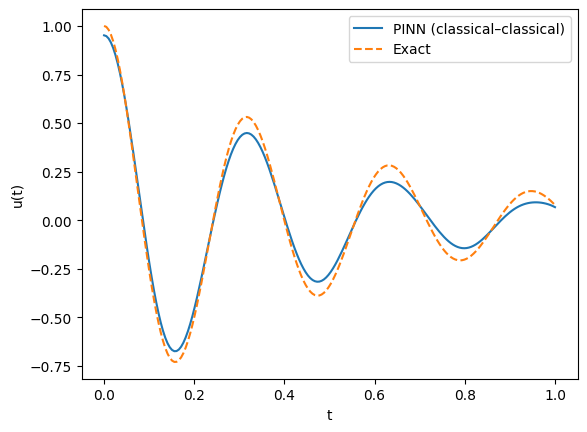

KeyboardInterrupt: 

In [13]:
model = CQ_PINN()
optimizer = torch.optim.Adam(model.parameters(), lr)

# t_train_torch = torch.linspace(0.0, 1.0, 200, dtype=torch.float32).reshape(-1, 1)

n_epochs = 20000

for epoch in range(n_epochs):
    optimizer.zero_grad()

    lic_u, lic_du, lf = loss_fn(model, t_train_torch)


    # Rebuild the total loss with the effective λ2
    loss = lic_u + lambda1 * lic_du + lambda2 * lf

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch:4d} | "
            f"Loss = {loss.item():.4e} | "
            f"IC_u = {lic_u:.4e} | "
            f"IC_du = {lic_du:.4e} | "
            f"PDE = {lf:.4e}"
        )

        t_diag = t_train_torch.clone().detach().requires_grad_(True)

        # compute u, du, d2u with graph
        u_diag  = model(t_diag)
        du_diag = derivative(u_diag, t_diag)
        d2u_diag = second_derivative(u_diag, t_diag)

        print(
            "||u||:", u_diag.abs().mean().item(),
            "||u'||:", du_diag.abs().mean().item(),
            "||u''||:", d2u_diag.abs().mean().item()
        )

        # 2) now you can disable gradients for numpy conversion
        with torch.no_grad():
            u_diag  = u_diag.squeeze().cpu().numpy()
            du_diag = du_diag.squeeze().cpu().numpy()
            d2u_diag = d2u_diag.squeeze().cpu().numpy()
            t_np = t_diag.squeeze().cpu().numpy()

        # plotting
        plt.figure(figsize=(10, 6))
        plt.plot(t_np, u_diag, label="u(t)")
        plt.plot(t_np, du_diag, label="u'(t)")
        plt.plot(t_np, d2u_diag, label="u''(t)")
        plt.legend()
        plt.xlabel("t")
        plt.title("Diagnostics: u, u', u'' after training")
        plt.grid(True)
        plt.show()

        omega = np.sqrt(k - (mu/2)**2)

        def u_exact(t):
            return np.exp(-mu*t/2) * (np.cos(omega*t) + (mu/(2*omega))*np.sin(omega*t))

        t_np = t_train_torch.cpu().numpy().flatten()
        u_pred = model(t_train_torch).detach().cpu().numpy().flatten()
        u_ex = u_exact(t_np)

        plt.plot(t_np, u_pred, label="PINN (classical–classical)")
        plt.plot(t_np, u_ex, '--', label="Exact")
        plt.legend()
        plt.xlabel("t")
        plt.ylabel("u(t)")
        plt.show()